# Modules

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

import os
from tqdm import tqdm

import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt

from h5py import File as h5File

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# GLOBAL PARAMETERS

In [3]:
DEBUG = False

IMG_OUTPUT_DIM = 100

IMAGING_TYPE = 'BACKGROUND_BRIGHT_WORM_DARK'
CROP_SIZE = 400
WINDOWSIZE_MIN_INCLUDED = 120
WINDOWSIZE_MIN_INCLUDED2 = WINDOWSIZE_MIN_INCLUDED//2
# THETA_MAX_DEVIATION = 360.0
GAMMA_MAX_DEVIATION = 0.2
# TODO: add scale changing which should change the bounds for x/y_min/max (sice size of included window should change)

if torch.cuda.is_available():
    DEVICE = 'cuda:0'
else:
    DEVICE = 'cpu'

# Data Classes

In [4]:
def rotate_xy(M, x, y):
    return np.matmul(
        M,
        np.array([x, y, 1])
    )

class AnnotatedDataLoader(Dataset):
    # Constructor
    def __init__(self, fp_annotated_data, factor_augmentations = 1):
        super().__init__()
        self.fp_annotated_data = fp_annotated_data
        self._data_file = h5File(self.fp_annotated_data)
        self.images = self._data_file['data']
        self.nrecords, self.ny, self.nx = self.images.shape
        self.coordinates = self._data_file['annotations']
        self.factor_augmentations = factor_augmentations
        self.n = self.nrecords * self.factor_augmentations
        return
    # Length
    def __len__(self):
        return self.n
    # Get Item
    def __getitem__(self, i):
        # Parameters
        idx = i // self.factor_augmentations
        # Choose randomly from 4 possible rotations: 0, 90, 180, 270 degrees
        theta = np.random.choice([ 0, 90, 180, 270 ])
        nx, ny = self.nx, self.ny
        img_processed = self.images[idx]
        y_idx, x_idx = self.coordinates[idx]
        label = 1
        if y_idx >= ny or x_idx >= nx:
            label = 0
            y_idx, x_idx = ny//2, nx//2
        # Gamma
        gamma = 1.0 + (np.random.rand()-0.5)*2*GAMMA_MAX_DEVIATION
        img_processed = ( (img_processed/255)**gamma * 255 ).astype(np.uint8)
        
        M_rotation = cv.getRotationMatrix2D((nx//2, ny//2), theta, 1.0)
        img_processed = cv.warpAffine(
            img_processed,
            M_rotation,
            (self.nx, self.ny),
            borderValue=255
        )
        coords_new = rotate_xy(M_rotation, x_idx, y_idx).astype(np.int32)
        
        # If Annotation is close to the edge, discard the "Minimum Window Criteria"
        # windowsize_min_included2 = WINDOWSIZE_MIN_INCLUDED2
        # if np.any(coords_new-windowsize_min_included2 < 0) or np.any(coords_new+windowsize_min_included2 >= np.array([nx, ny])):
        #     windowsize_min_included2 = 0
        #     if DEBUG:
        #         print(f"Annotation close to edge encountered! Image IDX: {idx} Label: {label}, Coords: {coords_new}")
        
        # TODO add passing conditions and handle missing annotation inside the frame
        for _ in range(3):
            # Annotation Outside after Rotation
            if np.any(coords_new >= np.array([nx, ny])) or np.any(coords_new < np.zeros(2)):
                if DEBUG:
                    print("Rotation@annotation outside image: {}-{} , shape:({},{})".format(
                        *coords_new,
                        nx, ny
                    ))
                continue
            if DEBUG:
                print(f"Image IDX: {idx} Label: {label}, COORD NEW: {coords_new}")
            x_idx_new, y_idx_new = coords_new
            # x_idx_min = max(
            #     x_idx_new + windowsize_min_included2 - CROP_SIZE,
            #     0
            # )
            # x_idx_max = min(
            #     x_idx_new - windowsize_min_included2,
            #     nx - CROP_SIZE
            # )
            # y_idx_min = max(
            #     y_idx_new + windowsize_min_included2 - CROP_SIZE,
            #     0
            # )
            # y_idx_max = min(
            #     y_idx_new - windowsize_min_included2,
            #     ny - CROP_SIZE
            # )
            # If Conditions
            ## X
            if x_idx_new <= WINDOWSIZE_MIN_INCLUDED2:
                x_idx_min, x_idx_max = 0, 0
            elif x_idx_new >= (nx - WINDOWSIZE_MIN_INCLUDED2):
                x_idx_min, x_idx_max = nx-CROP_SIZE, nx-CROP_SIZE
            elif x_idx_new <= nx//2:
                x_idx_min, x_idx_max = 0, min(x_idx_new - WINDOWSIZE_MIN_INCLUDED2, nx-CROP_SIZE)
            elif x_idx_new > nx//2:
                x_idx_min, x_idx_max = max(0, x_idx_new+WINDOWSIZE_MIN_INCLUDED2-CROP_SIZE), nx-CROP_SIZE
            else:
                print("HOY!!!!! X")
            ## Y
            if y_idx_new <= WINDOWSIZE_MIN_INCLUDED2:
                y_idx_min, y_idx_max = 0, 0
            elif y_idx_new >= (ny - WINDOWSIZE_MIN_INCLUDED2):
                y_idx_min, y_idx_max = ny-CROP_SIZE, ny-CROP_SIZE
            elif y_idx_new <= ny//2:
                y_idx_min, y_idx_max = 0, min(y_idx_new - WINDOWSIZE_MIN_INCLUDED2, ny-CROP_SIZE)
            elif y_idx_new > ny//2:
                y_idx_min, y_idx_max = max(0, y_idx_new+WINDOWSIZE_MIN_INCLUDED2-CROP_SIZE), ny-CROP_SIZE
            else:
                print("HOY!!!!! Y")
            # DEBUG
            if DEBUG:
                print("IDX X MIN-MAX: {}-{} , Y MIN-MAX: {}-{}".format(
                    x_idx_min, x_idx_max,
                    y_idx_min, y_idx_max
                ))
            # Empty Cropping Area
            if x_idx_max < x_idx_min or y_idx_max < y_idx_min:
                if DEBUG:
                    print("Empty crop area: {}-{} , {}-{}".format(
                        x_idx_min, x_idx_max,
                        y_idx_min, y_idx_max
                    ))
                continue
            if DEBUG:
                print(f"{x_idx_min}-{x_idx_max} , {y_idx_min}-{y_idx_max}")
            crop_topleft = np.random.randint(
                (y_idx_min, x_idx_min),
                (y_idx_max+1,x_idx_max+1)
            )  # so `x` can be used for index `i` in slicing and `y` for column indexing
            if DEBUG:
                print(f"{crop_topleft}")
            # Apply
            imin, jmin = crop_topleft
            imax, jmax = crop_topleft+CROP_SIZE
            img_processed = img_processed[imin:imax, jmin:jmax]
            coords_new -= crop_topleft[::-1]
            # Return
            if DEBUG:
                print(f"Image IDX: {idx} Label: {label}, COORD NEW Cropped: {coords_new}")
            return img_processed, coords_new, label
        print("DEBUG: Attempts to Augment failed!")
        print(f"Image IDX: {idx} Label: {label}, Coords: {coords_new}")
        raise NotImplementedError()
        # return self.images[idx], self.coordinates[idx]

# def rotate_xy(M, x_idx, y_idx):
#     return np.matmul(
#         M,
#         np.array([x_idx, y_idx, 1])
#     )

# class AnnotatedDataLoader(Dataset):
#     # Constructor
#     def __init__(self, images, coordinates, factor_augmentations = 1):
#         super().__init__()
#         self.images = images
#         self.nrecords, self.nx, self.ny = self.images.shape
#         self.coordinates = coordinates
#         self.factor_augmentations = factor_augmentations
#         self.n = self.nrecords * self.factor_augmentations
#         return
#     # Length
#     def __len__(self):
#         return self.n
#     # Get Item
#     def __getitem__(self, i):
#         if self.factor_augmentations == 1:
#             return self.images[i].copy(), self.coordinates[i].copy()
#         # Sample
#         nx, ny = self.nx, self.ny
#         idx = i//self.factor_augmentations
#         img_processed = self.images[idx]
#         x_idx, y_idx = self.coordinates[idx]
#         # Gamma
#         gamma = 1.0 + (np.random.rand()-0.5)*2*GAMMA_MAX_DEVIATION
#         img_processed = ( (img_processed/255)**gamma * 255 ).astype(np.uint8)
#         # TODO add passing conditions and handle missing annotation inside the frame
#         for _ in range(3):
#             # Rotation
#             theta = np.random.rand()*THETA_MAX_DEVIATION
#             M_rotation = cv.getRotationMatrix2D((nx//2, ny//2), theta, 1.0)
#             assert IMAGING_TYPE == 'BACKGROUND_BRIGHT_WORM_DARK', \
#                 "`borderValue` for rotation is set only for dark worm on bright background."
#             img_processed = cv.warpAffine(
#                 img_processed,
#                 M_rotation,
#                 (self.nx, self.ny),
#                 borderValue=255
#             )
#             # Offset
#             coords_new = rotate_xy(M_rotation, x_idx, y_idx).astype(np.int32)
#             # Annotation Outside after Rotation
#             if np.any(coords_new >= np.array([nx, ny])) or np.any(coords_new < np.zeros(2)):
#                 if DEBUG:
#                     print("Rotation@annotation outside image: {}-{} , shape:({},{})".format(
#                         *coords_new,
#                         nx, ny
#                     ))
#                 continue
#             if DEBUG:
#                 print(f"COORD NEW: {coords_new}")
#             x_idx_new, y_idx_new = coords_new
#             x_idx_min = max(
#                 x_idx_new + WINDOWSIZE_MIN_INCLUDED2 - CROP_SIZE,
#                 0
#             )
#             x_idx_max = min(
#                 x_idx_new - WINDOWSIZE_MIN_INCLUDED2,
#                 nx - CROP_SIZE
#             )
#             y_idx_min = max(
#                 y_idx_new + WINDOWSIZE_MIN_INCLUDED2 - CROP_SIZE,
#                 0
#             )
#             y_idx_max = min(
#                 y_idx_new - WINDOWSIZE_MIN_INCLUDED2,
#                 ny - CROP_SIZE
#             )
#             # Empty Cropping Area
#             if x_idx_max < x_idx_min or y_idx_max < y_idx_min:
#                 if DEBUG:
#                     print("Empty crop area: {}-{} , {}-{}".format(
#                         x_idx_min, x_idx_max,
#                         y_idx_min, y_idx_max
#                     ))
#                 continue
#             if DEBUG:
#                 print(f"{x_idx_min}-{x_idx_max} , {y_idx_min}-{y_idx_max}")
#             crop_topleft = np.random.randint(
#                 (x_idx_min, y_idx_min),
#                 (x_idx_max+1,y_idx_max+1)
#             )  # so `x` can be used for index `i` in slicing and `y` for column indexing
#             if DEBUG:
#                 print(f"{crop_topleft}")
#             # Apply
#             imin, jmin = crop_topleft
#             imax, jmax = crop_topleft+CROP_SIZE
#             img_processed = img_processed[imin:imax, jmin:jmax]
#             coords_new -= crop_topleft[::-1]
#             # Return
#             return img_processed, coords_new
#         print("DEBUG: Attempts to Augment failed!")
#         return self.images[idx].copy(), self.coordinates[idx].copy()
def collate_fn_3d_input(data):
    images, coords, _ = zip(*data)
    coords = np.array(coords)
    images = np.repeat(
        np.array(images)[:,None,:,:], 3, axis=1
    )
    images_channeled = torch.tensor( images, dtype=torch.float32 )
    coords = torch.tensor( coords, dtype=torch.float32 )
    return images_channeled, coords
def collate_fn_heatmap(data):
    images, coords, labels = zip(*data)
    _img = images[0]
    images = np.array(images)[:,None,:,:]
    images = torch.tensor( images, dtype=torch.float32 )
    heatmaps = []
    for (i,j), label in zip(coords,labels):
        if label != 0:
            img_annotated = np.zeros_like( _img, dtype=np.float32 )
            img_annotated[j,i] = 100.0
            img_annotated = cv.GaussianBlur(img_annotated,(11,11), 0)
            img_annotated = cv.resize(img_annotated, (IMG_OUTPUT_DIM, IMG_OUTPUT_DIM))
            img_annotated /= img_annotated.max()
        else:
            img_annotated = np.zeros( (IMG_OUTPUT_DIM, IMG_OUTPUT_DIM), dtype=np.float32 )
        heatmaps.append(img_annotated.flatten())
    heatmaps = torch.tensor( np.array(heatmaps), dtype=torch.float32 )
    return images, heatmaps

# Convert Data

# Data Loader

In [5]:
dataset = AnnotatedDataLoader(
    fp_annotated_data=r"V:\Mahdi\OpenAutoScope2.0\data\training_data\training_data.h5",
    factor_augmentations = 5
)

In [6]:
dataloader = DataLoader(
    dataset,
    batch_size=32, shuffle=True,
    collate_fn=collate_fn_heatmap
)

# Model

In [7]:
# Model
class Model(nn.Module):
    def __init__(self, input_image_shape = (400, 400)):
        super().__init__()
        self.input_image_shape = input_image_shape
        self.input_nx, self.input_ny = self.input_image_shape
        # Convolutions
        self.conv1_nchannels = 1
        self.conv1_nconvs = 4
        self.conv1_convsize = 25
        self.conv1 = nn.Conv2d(
            self.conv1_nchannels,
            self.conv1_nconvs,
            self.conv1_convsize
        )
        self.conv1_activation = nn.ReLU()
        self.conv1_npooling = 5
        self.conv1_poolingstride = 2
        self.conv1_pooling = nn.MaxPool2d(
            self.conv1_npooling,
            stride=self.conv1_poolingstride
        )
        # TODO: add max_pooling layers
        # https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d
        # Flatten
        self.flatten = nn.Flatten()
        # Denses
        self.linear1 = nn.Linear(
            in_features=138384,  # TODO calculate this based on parameters above, e.g. self.conv1_convsize, ...
            out_features=512
        )
        self.linear1_activation = nn.ReLU()
        self.dense = nn.Linear(
            in_features=512,
            out_features=IMG_OUTPUT_DIM**2
        )
        self.to_probability = nn.Sigmoid()
        return

    def forward(self, x):
        # Convolutions
        x = self.conv1_activation(self.conv1(x))
        x = self.conv1_pooling(x)
        # Flattern
        x = self.flatten(x)
        # Dense
        x = self.linear1_activation(
            self.linear1(x)
        )
        x = self.dense(x)
        return self.to_probability(x)

# Training

In [8]:
model = Model()
checkpoint = torch.load(
    r"V:\Mahdi\OpenAutoScope2.0\data\trained_models\2023-06-20_171411\003.pt"
)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [9]:
epoch

3

In [11]:
model

Model(
  (conv1): Conv2d(1, 4, kernel_size=(25, 25), stride=(1, 1))
  (conv1_activation): ReLU()
  (conv1_pooling): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=138384, out_features=512, bias=True)
  (linear1_activation): ReLU()
  (dense): Linear(in_features=512, out_features=10000, bias=True)
  (to_probability): Sigmoid()
)

In [12]:
DEVICE = 'cpu'

In [13]:
loss_fn = torch.nn.BCELoss()

In [14]:
epochs = tqdm( range(1), desc=f'Loss: {0.0:>7.3f}', position=0 )
for i_epoch in epochs:
    losses_epoch = []
    steps = tqdm(dataloader, desc=f'Epoch Steps - Loss: {0.0:>7.3f}',position=1, leave=False)
    for x_train, y_train in steps:
        x_train = x_train.to(DEVICE)
        y_train = y_train.to(DEVICE)

        # Make predictions for this batch
        with torch.no_grad():
            y_train_pred = model(x_train)

            # Compute the loss and its gradients
            loss = loss_fn(y_train_pred, y_train)
            loss_value = loss.cpu().item()
            # Log
            losses_epoch.append(loss_value)
            steps.set_description(
                'Epoch Steps - Loss: {:>7.3f}'.format(loss_value)
            )
    logs.append([
        np.mean(losses_epoch),
        losses_epoch.copy()
    ])
    # Report
    epochs.set_description(
        'Loss: {:>7.3f}'.format( logs[-1][0] )
    )

Loss:   0.000:   0%|                                                                                                                                  | 0/1 [00:05<?, ?it/s]


KeyboardInterrupt: 

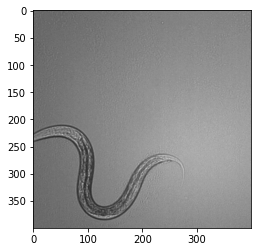

In [17]:
idx = 0
plt.imshow(
    x_train[idx][0].numpy(),
    cmap='gray',
    vmin=0, vmax=255
)

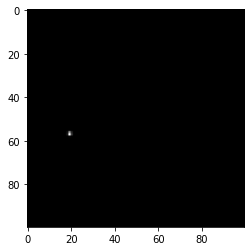

In [18]:
idx = 0
plt.imshow(
    np.resize(y_train[idx].numpy(), (100,100)),
    cmap='gray'
)

In [23]:
y_train_pred[idx].max()

tensor(0.0055)

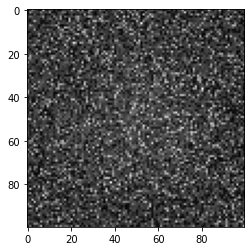

In [19]:
idx = 0
plt.imshow(
    np.resize(y_train_pred[idx].numpy(), (100,100)),
    cmap='gray'
)